## **Dependencias**

In [1]:
%pip install -q agentpy numpy matplotlib seaborn ipywidgets

Note: you may need to restart the kernel to use updated packages.


## **Imports y estilo**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import agentpy as ap
import matplotlib.patches as mpatches

In [5]:
def unit(v):
    n = np.linalg.norm(v)
    return v / (n + 1e-9)

def polyline_length(P):
    return sum(np.linalg.norm(P[i+1]-P[i]) for i in range(len(P)-1))

def advance_along_polyline(P, s, ds):
    seglen = [np.linalg.norm(P[i+1]-P[i]) for i in range(len(P)-1)]
    cum = np.cumsum([0.0] + seglen)
    L = cum[-1]
    s2 = min(s + ds, L)

    i = np.searchsorted(cum, s2, side='right') - 1
    i = max(0, min(i, len(P)-2))
    t = (s2 - cum[i]) / (seglen[i] + 1e-9)
    xy = P[i] + t * (P[i+1] - P[i])
    return s2, xy

def dir_at(P, s):
    seglen = [np.linalg.norm(P[i+1]-P[i]) for i in range(len(P)-1)]
    cum = np.cumsum([0.0] + seglen)
    i = np.searchsorted(cum, s, side='right') - 1
    i = max(0, min(i, len(P)-2))
    d = P[i+1] - P[i]
    return unit(d)

def project_s(P, xy, samples=400):
    L = polyline_length(P)
    best = (1e9, 0.0)
    for k in range(samples):
        s = L * k / (samples - 1)
        _, p = advance_along_polyline(P, 0.0, s)
        d = np.linalg.norm(p - xy)
        if d < best[0]:
            best = (d, s)
    return best[1]



## **Parámetros**

In [6]:
params = {
    'green_rc_e': 55,
    'green_rc_w': 55,
    'green_ind' : 28,
    'yellow'    : 8,
    'all_red'   : 2,

    'lambda_RC_E': 0.18,
    'lambda_RC_W': 0.16,
    'lambda_IND' : 0.08,

    'p_ind_to_E': 0.55,

    'v_mean': 1.8,
    'lane_w': 3.5,
    'Ldraw' : 120.0,

    'min_gap': 4.5,
    'react_pad': 0.6,
}


w  = params['lane_w']
Ld = params['Ldraw']

theta = np.deg2rad(+10)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

off = w*1.2
RC_E_poly = (np.array([[-Ld, -off], [   0.0, -off], [ Ld, -off]]) @ R.T)
RC_W_poly = (np.array([[ Ld,  +off], [   0.0, +off], [-Ld, +off]]) @ R.T)

IND_poly = np.array([
    [  0.0, -Ld],
    [ -2.0, -40.0],
    [ -4.0, -22.0],
    [ -6.0, -10.0],
    [ -8.0,  -off]
]) @ R.T

def stop_s(P, x_ref=0.0):
    L = polyline_length(P)
    best = (1e9, 0.0)
    for k in range(220):
        s = L * k / 219
        _, xy = advance_along_polyline(P, 0.0, s)
        err = abs(xy[0] - x_ref)
        if err < best[0]:
            best = (err, s)
    return best[1]

RC_E_stop = stop_s(RC_E_poly, x_ref=0.0)
RC_W_stop = stop_s(RC_W_poly, x_ref=0.0)
IND_stop  = stop_s(IND_poly,  x_ref=-6.0)

MERGE_XY = IND_poly[-1]
MERGE_S_ON_RC_E = project_s(RC_E_poly, MERGE_XY)
MERGE_S_ON_RC_W = project_s(RC_W_poly, MERGE_XY)


LANES = {
    'RC_E': {'P': RC_E_poly, 'stop_s': RC_E_stop, 'signal': 'RC_E', 'spawn_lambda': 'lambda_RC_E'},
    'RC_W': {'P': RC_W_poly, 'stop_s': RC_W_stop, 'signal': 'RC_W', 'spawn_lambda': 'lambda_RC_W'},
    'IND' : {'P': IND_poly,  'stop_s': IND_stop,  'signal': 'IND',  'spawn_lambda': 'lambda_IND'},
}

STOP_BACK_RC_E = 7.0
RC_E_stop = max(0.0, MERGE_S_ON_RC_E - STOP_BACK_RC_E)

LANES['RC_E']['stop_s'] = RC_E_stop

params.update({
    'ind_shift_down': 4.0,
})

IND_poly = IND_poly + np.array([0.0, -params['ind_shift_down']])

IND_stop  = stop_s(IND_poly,  x_ref=-6.0)
MERGE_XY = IND_poly[-1]
MERGE_S_ON_RC_E = project_s(RC_E_poly, MERGE_XY)
MERGE_S_ON_RC_W = project_s(RC_W_poly, MERGE_XY)

LANES['IND']['P'] = IND_poly
LANES['IND']['stop_s'] = IND_stop

# Colores de carrito por origen de generación
COLOR_BY_SRC = {
    'RC_E': '#6A0DAD',  # morado
    'RC_W': '#FF8C00',  # naranja
    'IND' : '#1E88E5',  # azul
}




## **Controlador de semáforos**

In [7]:
class Signals(ap.Agent):
    def setup(self, green_rc_e, green_rc_w, green_ind, yellow, all_red):
        self.g_main = int(max(green_rc_e, green_rc_w))
        self.g_ind  = int(green_ind)
        self.y      = int(yellow)
        self.ar     = int(all_red)

        self.phase = 0
        self.sub   = 'G'
        self.t     = 0

    def _green_time(self):
        return self.g_main if self.phase == 0 else self.g_ind

    def lights(self):
        L = {'RC_E': 'R', 'RC_W': 'R', 'IND': 'R'}
        if self.sub == 'AR':
            return L
        if self.phase == 0:
            L['RC_E'] = self.sub
            L['RC_W'] = self.sub
        else:
            L['IND']  = self.sub
        return L

    def step(self):
        self.t += 1
        if self.sub == 'G' and self.t >= self._green_time():
            self.sub, self.t = 'Y', 0
        elif self.sub == 'Y' and self.t >= self.y:
            self.sub, self.t = 'AR', 0
        elif self.sub == 'AR' and self.t >= self.ar:
            self.phase = (self.phase + 1) % 2
            self.sub, self.t = 'G', 0

## **Agente Vehículo**

In [8]:
class Car(ap.Agent):
    def setup(self, lane_id, p):
        self.src = lane_id
        self.color = COLOR_BY_SRC.get(self.src, '#424242')

        self.lane_id = lane_id
        L = LANES[lane_id]
        self.P = L['P']
        self.s = 0.0
        self.pos = self.P[0].astype(float)
        self.v = max(0.8, np.random.normal(p.v_mean, 0.25))
        self.stop_s = L['stop_s']
        self.signal_group = L['signal']

        self.min_gap = p.min_gap
        self.react_pad = p.react_pad

        if self.lane_id == 'IND':
            self.ind_target = 'RC_E' if (np.random.rand() < p.p_ind_to_E) else 'RC_W'

    def at_goal(self):
        return self.s >= polyline_length(self.P) - 1e-3

    def red_here(self):
        if self.signal_group is None or self.stop_s is None:
            return False
        col = self.model.signals.lights()[self.signal_group]
        return col in ('R', 'Y')

    def leader_gap(self):
        """Distancia sobre la polilínea al coche líder en mi mismo carril.
        Devuelve None si no hay líder delante."""
        ahead = [c for c in self.model.cars if c is not self and c.lane_id == self.lane_id and c.s > self.s]
        if not ahead:
            return None
        s_lead = min(c.s for c in ahead)
        return max(0.0, s_lead - self.s)

    # Cambio de carril del sector sur-norte (blvd. Primavera)
    def switch_to(self, new_lane, start_s):
        self.lane_id = new_lane
        L2 = LANES[new_lane]
        self.P = L2['P']
        self.stop_s = L2['stop_s']
        self.signal_group = L2['signal']
        self.s, self.pos = advance_along_polyline(self.P, 0.0, start_s)

    def step(self):
        hold = 0.8

        red = self.red_here()
        if red:
            if self.s < self.stop_s:
                ds = min(self.v, max(0.0, self.stop_s - self.s))
                gap = self.leader_gap()
                if gap is not None:
                    ds = min(ds, max(0.0, gap - self.min_gap + self.react_pad))
                self.s, self.pos = advance_along_polyline(self.P, self.s, ds)
                return
            if self.s <= self.stop_s + hold:
                self.s = self.stop_s
                _, self.pos = advance_along_polyline(self.P, 0.0, self.s)
                return

        ds = self.v
        gap = self.leader_gap()
        if gap is not None:
            ds = min(ds, max(0.0, gap - self.min_gap + self.react_pad))
        s_old = self.s
        self.s, self.pos = advance_along_polyline(self.P, self.s, ds)

        if red and s_old < self.stop_s <= self.s:
            self.s = self.stop_s
            _, self.pos = advance_along_polyline(self.P, 0.0, self.s)

        if self.lane_id == 'IND' and self.at_goal():
            if self.ind_target == 'RC_E':
                start_s = MERGE_S_ON_RC_E + self.min_gap*0.4
                self.switch_to('RC_E', start_s)
            else:
                start_s = MERGE_S_ON_RC_W + self.min_gap*0.4
                self.switch_to('RC_W', start_s)


## **Modelo**

In [9]:
class Intersection(ap.Model):
    def setup(self):
        self.signals = Signals(
            self,
            self.p.green_rc_e,
            self.p.green_rc_w,
            self.p.green_ind,
            self.p.yellow,
            self.p.all_red
        )
        self.cars = ap.AgentList(self, 0, Car)
        self.t = 0

    def spawn_lane(self, lane_id, lam):
        if np.random.rand() < lam:
            self.cars.append(Car(self, lane_id=lane_id, p=self.p))

    def step(self):
        self.t += 1
        for lid, L in LANES.items():
            self.spawn_lane(lid, getattr(self.p, L['spawn_lambda']))
        self.signals.step()
        for car in list(self.cars):
            car.step()
            if car.at_goal() and car.lane_id in ('RC_E', 'RC_W'):
                self.cars.remove(car)


## **Función de animación (animation_plot)**

In [10]:
def draw_intersection(ax):
    ax.clear()
    Ld = params['Ldraw']
    ax.set_xlim(-Ld, Ld); ax.set_ylim(-Ld, Ld)
    ax.set_aspect('equal'); ax.set_xticks([]); ax.set_yticks([])

    for lid, L in LANES.items():
        P = L['P']
        xs, ys = P[:,0], P[:,1]
        ax.plot(xs, ys, lw=14, color='#e0e0e0', solid_capstyle='round', zorder=0)
        ax.plot(xs, ys, lw=2, color='#c0c0c0', zorder=1)

    for lid, L in LANES.items():
        if L['signal'] and L['stop_s'] is not None:
            s = L['stop_s']
            _, xy = advance_along_polyline(L['P'], 0.0, s)
            d = dir_at(L['P'], s)
            n = np.array([-d[1], d[0]])
            p1 = xy - n*5
            p2 = xy + n*5
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='yellow', lw=3)

def my_plot(model, ax):
    draw_intersection(ax)

    for car in model.cars:
        ax.plot(car.pos[0], car.pos[1], 'o', ms=6, color=car.color,
            markeredgecolor='black',
            markeredgewidth=0.4)

    lights = model.signals.lights()
    colors = {'G':'green','Y':'yellow','R':'red'}

    offset_out = model.p.lane_w * 2.2

    signal_side = {
        'RC_E': -1,
        'RC_W': +1,
        'IND' : -1,
    }

    for gid in ['RC_E','RC_W','IND']:
        s_stop = LANES[gid]['stop_s']
        P      = LANES[gid]['P']
        _, xy  = advance_along_polyline(P, 0.0, s_stop)
        d      = dir_at(P, s_stop)
        n      = np.array([-d[1], d[0]])
        side   = signal_side[gid]
        xy_f   = xy + side * n * offset_out
        col    = colors[lights[gid]]
        ax.add_patch(plt.Circle((xy_f[0], xy_f[1]), 1.6, color=col, zorder=6))

    legend_patches = [
    mpatches.Patch(color=COLOR_BY_SRC['RC_E'], label='Oeste → Este (RC_E)'),
    mpatches.Patch(color=COLOR_BY_SRC['RC_W'], label='Este → Oeste (RC_W)'),
    mpatches.Patch(color=COLOR_BY_SRC['IND'],  label='Sur → Norte (IND)'),
    ]
    ax.legend(handles=legend_patches, loc='upper right', frameon=True)


## **Interfaz de la simulación**

In [12]:
# -------------------------
#          Interfaz
# -------------------------
import ipywidgets as w
from IPython.display import display, clear_output
from matplotlib import rc
rc('animation', html='jshtml')

# Controles de la interfaz
sl_main     = w.IntSlider(value=int(params.get('green_rc_e', 55)), min=30, max=90, step=5, description='G principal (s)')
sl_ind      = w.IntSlider(value=int(params.get('green_ind', 28)),  min=10, max=60, step=5, description='G IND (s)')
sl_y        = w.IntSlider(value=int(params.get('yellow', 4)),      min=3,  max=6,  step=1, description='Ámbar (s)')
sl_ar       = w.IntSlider(value=int(params.get('all_red', 2)),     min=1,  max=4,  step=1, description='All-Red (s)')
sl_steps    = w.IntSlider(value=240, min=120, max=1200, step=60, description='Duración anim (s)')
sl_interval = w.IntSlider(value=60,  min=30,  max=150, step=10, description='Interval (ms/frame)')

btn = w.Button(description='Actualizar simulación', button_style='primary', icon='refresh')
metrics_out = w.Output()
anim_out    = w.Output()

def compute_kpis(steps=600):
    """KPIs rápidos (proxy) sin animación: delay ~ tiempo en cola, colas máximas por carril."""
    m = Intersection(params)

    if not hasattr(m, 'cars'):
        m.setup()

    delay_proxy = 0
    maxq = {'RC_E': 0, 'RC_W': 0, 'IND': 0}

    for _ in range(steps):
        # Colas: vehículos antes de la línea de alto
        for lid in ['RC_E', 'RC_W', 'IND']:
            stop_s = LANES[lid]['stop_s']
            q = sum(
                1 for c in getattr(m, 'cars', [])
                if c.lane_id == lid and c.s <= stop_s + 0.8
            )
            if q > maxq[lid]:
                maxq[lid] = q

        # Delay proxy = #veh en cola este paso (veh·s)
        delay_proxy += sum(
            1 for c in m.cars
            if c.s <= (LANES[c.lane_id]['stop_s'] + 0.8)
        )

        m.step()

    return {
        'Delay_proxy (veh·s)': int(delay_proxy),
        'MaxQueue_RC_E': maxq['RC_E'],
        'MaxQueue_RC_W': maxq['RC_W'],
        'MaxQueue_IND' : maxq['IND'],
    }

def run_render(_=None):
    # 1) Sincronizar la variable de params con los sliders de pyWidgets
    params['green_rc_e'] = int(sl_main.value)
    params['green_rc_w'] = int(sl_main.value)
    params['green_ind']  = int(sl_ind.value)
    params['yellow']     = int(sl_y.value)
    params['all_red']    = int(sl_ar.value)

    # 2) KPIs
    with metrics_out:
        clear_output(wait=True)
        k = compute_kpis(steps=min(600, int(sl_steps.value)))
        print("KPIs aproximados:")
        for k_, v_ in k.items():
            print(f"  - {k_}: {v_}")

    # 3) Animación
    with anim_out:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7,7))
        model = Intersection(params)
        anim = ap.animate(model, fig, ax, my_plot,
                          steps=int(sl_steps.value),
                          interval=int(sl_interval.value))
        display(anim)

btn.on_click(run_render)

ui = w.VBox([
    w.HTML('<b>Control de tiempos del semáforo</b>'),
    sl_main, sl_ind, sl_y, sl_ar,
    w.HBox([sl_steps, sl_interval]),
    btn,
    w.HTML('<hr><b>KPIs</b>'),
    metrics_out,
    w.HTML('<hr><b>Animación</b>'),
    anim_out
])

display(ui)
run_render()

ModuleNotFoundError: No module named 'ipywidgets'

## **Gráficas de resultados**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ALPHA = 1.0
BETA  = 0.5
GAMMA = 0.2

def simulate_and_measure(G_main, G_ind, Y, AR, steps=600):
    params['green_rc_e'] = int(G_main)
    params['green_rc_w'] = int(G_main)
    params['green_ind']  = int(G_ind)
    params['yellow']     = int(Y)
    params['all_red']    = int(AR)

    m = Intersection(params)
    if not hasattr(m, 'cars'):
        m.setup()

    lanes = ['RC_E', 'RC_W', 'IND']
    queue_ts = {lid: [] for lid in lanes}
    maxq     = {lid: 0  for lid in lanes}
    delay_proxy = 0
    throughput  = {lid: 0 for lid in lanes}

    green_steps  = {'RC_E':0, 'RC_W':0, 'IND':0}
    green_demand = {'RC_E':0, 'RC_W':0, 'IND':0}

    prev_s = {}

    for t in range(steps):
        lights_before = m.signals.lights()

        for lid in lanes:
            stop_s = LANES[lid]['stop_s']
            q = sum(1 for c in getattr(m, 'cars', []) if c.lane_id == lid and c.s <= stop_s + 0.8)
            queue_ts[lid].append(q)
            if q > maxq[lid]:
                maxq[lid] = q
        delay_proxy += sum(queue_ts[lid][-1] for lid in lanes)

        for gid in ['RC_E','RC_W','IND']:
            if lights_before[gid] == 'G':
                green_steps[gid] += 1
                demand_q = queue_ts[gid][-1] if len(queue_ts[gid])>0 else 0
                if demand_q > 0:
                    green_demand[gid] += 1

        prev_s.clear()
        for c in m.cars:
            prev_s[c.id] = (c.lane_id, c.s)

        m.step()

        for c in m.cars:
            if c.id in prev_s:
                old_lane, s_old = prev_s[c.id]
                if old_lane in LANES and LANES[old_lane]['stop_s'] is not None:
                    s_stop = LANES[old_lane]['stop_s']
                    if (s_old < s_stop <= c.s) and (lights_before[LANES[old_lane]['signal']] == 'G'):
                        throughput[old_lane] += 1

    throughput_total = sum(throughput[lid] for lid in ['RC_E','RC_W'])
    J = ALPHA*delay_proxy + BETA*max(maxq.values()) - GAMMA*throughput_total

    green_util = {}
    for g in ['RC_E','RC_W','IND']:
        if green_steps[g] > 0:
            green_util[g] = 100.0 * green_demand[g] / green_steps[g]
        else:
            green_util[g] = 0.0

    return {
        'delay_proxy': int(delay_proxy),
        'max_queue':   maxq,
        'throughput':  throughput,
        'throughput_total': int(throughput_total),
        'green_util_%': green_util,
        'J': float(J),
        'queue_ts': queue_ts
    }


Mejor combinación: {'Verde en Av.': 70, 'Verde en Blvd.': 20, 'valor': 29310}


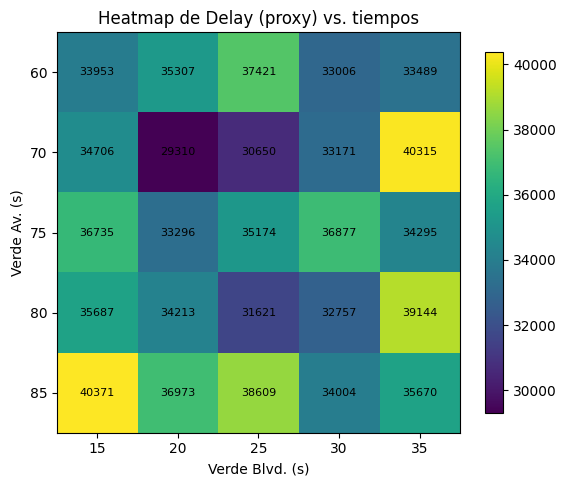

In [ ]:
G_MAIN_vals = [60, 70, 75, 80, 85]
G_IND_vals  = [15, 20, 25, 30, 35]

metric_matrix = np.zeros((len(G_MAIN_vals), len(G_IND_vals)), dtype=float)
best = None

for i, Gm in enumerate(G_MAIN_vals):
    for j, Gi in enumerate(G_IND_vals):
        res = simulate_and_measure(Gm, Gi, Y=params.get('yellow',5), AR=params.get('all_red',1), steps=900)
        value = res['delay_proxy']
        metric_matrix[i, j] = value
        if (best is None) or (value < best[0]):
            best = (value, Gm, Gi, res)

print("Mejor combinación:", {"Verde en Av.": best[1], "Verde en Blvd.": best[2], "valor": best[0]})

fig, ax = plt.subplots(figsize=(6.5,5.2))
im = ax.imshow(metric_matrix, aspect='auto')

ax.set_xticks(range(len(G_IND_vals)))
ax.set_xticklabels(G_IND_vals)
ax.set_yticks(range(len(G_MAIN_vals)))
ax.set_yticklabels(G_MAIN_vals)
ax.set_xlabel("Verde Blvd. (s)")
ax.set_ylabel("Verde Av. (s)")
ax.set_title("Heatmap de Delay (proxy) vs. tiempos")

for i in range(metric_matrix.shape[0]):
    for j in range(metric_matrix.shape[1]):
        ax.text(j, i, f"{int(metric_matrix[i,j])}", ha='center', va='center', fontsize=8)

fig.colorbar(im, ax=ax, shrink=0.9)
plt.show()

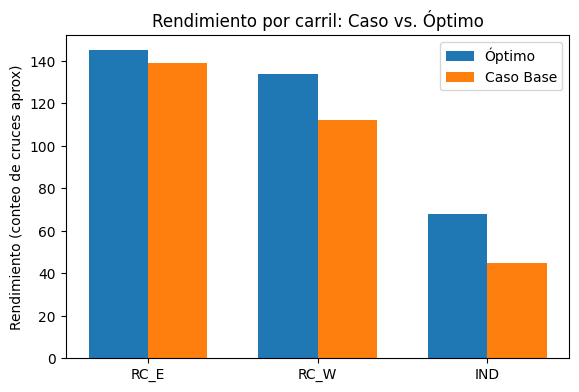

In [ ]:
BASE_G_MAIN = 85
BASE_G_IND  = 30

res_base = simulate_and_measure(BASE_G_MAIN, BASE_G_IND, Y=params.get('yellow',5), AR=params.get('all_red',1), steps=900)
res_best = best[3]

lanes_plot = ['RC_E','RC_W','IND']
base_vals  = [res_base['throughput'][lid] for lid in lanes_plot]
best_vals  = [res_best['throughput'][lid] for lid in lanes_plot]

x = np.arange(len(lanes_plot))
w = 0.35

fig, ax = plt.subplots(figsize=(6.5,4.2))
ax.bar(x - w/2, base_vals, width=w, label='Caso base')
ax.bar(x + w/2, best_vals, width=w, label='Óptimo')
ax.set_xticks(x)
ax.set_xticklabels(lanes_plot)
ax.set_ylabel("Rendimiento (conteo de cruces aprox)")
ax.set_title("Rendimiento por carril: Caso vs. Óptimo")
ax.legend()
plt.show()


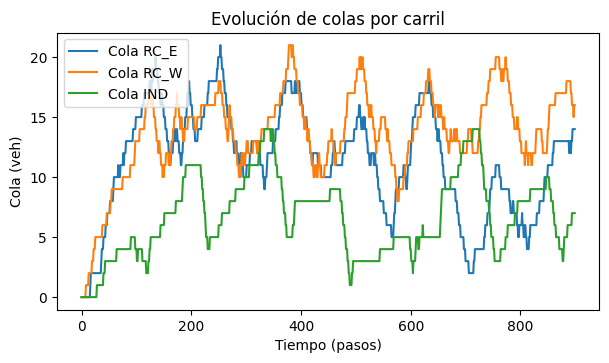

In [ ]:
res = res_best

fig, ax = plt.subplots(figsize=(7,3.6))
for lid in ['RC_E','RC_W','IND']:
    ax.plot(res['queue_ts'][lid], label=f"Cola {lid}")
ax.set_xlabel("Tiempo (pasos)")
ax.set_ylabel("Cola (veh)")
ax.set_title("Evolución de colas por carril")
ax.legend()
plt.show()

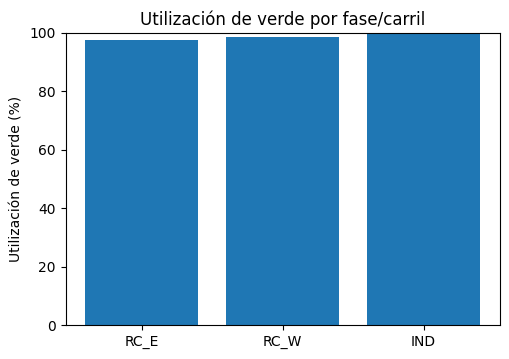

In [ ]:
res = res_best

labels = ['RC_E','RC_W','IND']
vals   = [res['green_util_%'][g] for g in labels]

fig, ax = plt.subplots(figsize=(5.6,3.8))
ax.bar(labels, vals)
ax.set_ylim(0, 100)
ax.set_ylabel("Utilización de verde (%)")
ax.set_title("Utilización de verde por fase/carril")
plt.show()


In [ ]:
import pandas as pd

def resumen_row(nombre, Gm, Gi, res):
    return {
        "Escenario": nombre,
        "Verde en Av. (s)": Gm,
        "Verde en Blvd. (s)": Gi,
        "Delay_proxy (veh·s)": res['delay_proxy'],
        "MaxCola_Av_Este": res['max_queue']['RC_E'],
        "MaxCola_Av_Oeste": res['max_queue']['RC_W'],
        "MaxCola_Blvd" : res['max_queue']['IND'],
        "Rendimiento_total": res['throughput_total'],
        "J": round(res['J'], 2),
        "Util_green_Av_Este (%)": round(res['green_util_%']['RC_E'],1),
        "Util_green_Av_Oeste (%)": round(res['green_util_%']['RC_W'],1),
        "Util_green_Blvd  (%)": round(res['green_util_%']['IND'],1),
    }

df = pd.DataFrame([
    resumen_row("Óptimo", BASE_G_MAIN, BASE_G_IND, res_base),
    resumen_row("Caso base",   best[1],     best[2],   res_best),
])
df


Escenario  Verde en Av. (s)  Verde en Blvd. (s)  Delay_proxy (veh·s)  \
0  Caso base                85                  30                36409   
1     Óptimo                85                  30                28517   

   MaxCola_Av_Este  MaxCola_Av_Oeste  MaxCola_Blvd  Rendimiento_total  \
0               27                31            17                275   
1               21                21            14                239   

         J  Util_green_Av_Este (%)  Util_green_Av_Oeste (%)  \
0  36369.5                    99.0                     99.2   
1  28479.7                    97.4                     98.7   

   Util_green_Blvd  (%)  
0                 100.0  
1                 100.0